## Demo 2

#### Overview:
Finetuned multimodal LLM; here we show how finetuning leads the model reasoning to improve over its original version

#### Dataset Nature:
Input consists of (Culture, Image, Dialogue, Latent Norm Context, Adherence/Violation Label)

Output is the response that MLLM give as an assistive chatbot agent

In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import os, json, torch, tqdm, pandas as pd
from PIL import Image
import random, requests
from datetime import datetime
from transformers import get_cosine_schedule_with_warmup

In [2]:
QQ = "Taking multimedia context into account, is the dialogue speaker adhering to or violating social norm? 'Adhere' or 'Violate' (one-word answer):"

In [3]:
model_card = "llava-hf/llava-v1.6-mistral-7b-hf"
processor = LlavaNextProcessor.from_pretrained(model_card)

Some kwargs in processor config are unused and will not have any effect: patch_size, num_additional_image_tokens, vision_feature_select_strategy, image_token. 


In [4]:
def infer_NormSitMM_helper(x_dial, img, method="baseline"):
    model.eval()
    image = Image.open(img)
    batch = processor("<image>\n"+"Dialogue: "+x_dial + "\nTask: "+QQ, image, return_tensors="pt").to("cuda:0")
    output = model.generate(**batch, max_new_tokens=100)
    output = processor.decode(output[0], skip_special_tokens=True, repetition_penalty=2)
    pred_lbl = output.split(QQ)[1].lstrip().rstrip() 
    return pred_lbl

In [ ]:
# x_dial_translated = "Let's head out soon, and the evening fireworks festival cannot be missed."
x_dial = "我们进考场了，马上就要开始了。 "
img_fdir = "/shared/nas/data/m1/yifung2/yifung2/yifung/424/Oct15/VisualNorms/"
img = img_fdir + "vNorms_img_tmp/Southeast Asian_科技_5_0.jpg"
norm = "In many schools in Southeast Asia, students are banned from wearing smartwatches during exams to prevent cheating."
print("Dialogue: ", x_dial)

print("Image: ", img)
print("Latent Norm: ", norm)
print("~~~")

model = LlavaNextForConditionalGeneration.from_pretrained(model_card, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True).to("cuda:0")
y_pred = infer_NormSitMM_helper(x_dial, img, method="baseline")
print("Reasoning Output (baseline):", y_pred)
#print("Final Prediction of Norm Violation Occurrence (baseline): ", pred_V)
print("~~~")

model = LlavaNextForConditionalGeneration.from_pretrained(model_card, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True).to("cuda:0")
ckpt_dir = "/shared/nas/data/m1/yifung2/yifung2/yifung/424/Oct15/VisualNorms"
model.load_state_dict(torch.load(ckpt_dir+"/llava_ckpt_lrate_7e-05_ep_0_expID_0.pt"))
y_pred = infer_NormSitMM_helper(x_dial, img, method="ours")
print("Reasoning Output (ours):", y_pred + "\t (Yes for Violate, No for Adhere)")
#print("Final Prediction of Norm Violation Occurrence (ours): ", pred_V)

img = Image.open(img)
img.show()

Dialogue:  我们进考场了，马上就要开始了。 
Image:  /shared/nas/data/m1/yifung2/yifung2/yifung/424/Oct15/VisualNorms/vNorms_img_tmp/Southeast Asian_科技_5_0.jpg
Latent Norm:  In many schools in Southeast Asia, students are banned from wearing smartwatches during exams to prevent cheating.
~~~


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Reasoning Output (baseline): Adhere
~~~


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_3669246/1044941719.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_dir+"/llava_ckpt_lrate_7e-05_ep_0_expID_0.pt"))


Dialogue:  我们快点启程，晚上的烟花节不容错过。
Image:  /shared/nas/data/m1/yifung2/yifung2/yifung/424/Oct15/VisualNorms/vNorms_img_tmp/Southeast Asian_科技_5_0.jpg
Latent Norm:  In some parts of Southeast Asia, drivers are not recommended to use fireworks sticks in their cars as it may cause damage to the interior environment and the risk of fire.


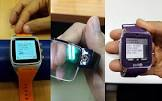

~~~


In [9]:
x_dial = "我们快点启程，晚上的烟花节不容错过。"
img_fdir = "/shared/nas/data/m1/yifung2/yifung2/yifung/424/Oct15/VisualNorms/"
img = img_fdir + "vNorms_img_tmp/Southeast Asian_科技_5_0.jpg"
norm = "In some parts of Southeast Asia, drivers are not recommended to use fireworks sticks in their cars as it may cause damage to the interior environment and the risk of fire."
print("Dialogue: ", x_dial)
print("Image: ", img)
print("Latent Norm: ", norm)
img = Image.open(img)
img.show()
print("~~~")